# IMDb with Vanilla RNNs
**7/14/2020**


## IMDb Movie Review Dataset and Preprocessing

The IMDb Movie Review Dataset contains 50,000 reviews, split 50/50 into positive and negative reviews. The goal is to create a model that can accurately predict the sentiment (positive or negative) of a given review.

In [1]:
import torch
from torch import nn, optim
from torchtext import data, datasets
import torch.nn.functional as F
import spacy
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
import numpy as np
import random
import time
import json
from livelossplot import PlotLosses
import warnings
warnings.filterwarnings('ignore')

In order for a review to become the input of a neural network, we need to preprocess the text. The first step is to tokenize the text, meaning to break up the text into individual units that are easily understood, such as words. The spacy tokenizer does this fairly well by splitting text by spaces and separating punctuation. The reviews also contain &lt;br /&gt; tags which need to be removed, which necessitates a custom tokenizer based on spacy.

In [2]:
def custom_tokenizer(text):
    nlp = spacy.load('en_core_web_sm', disable = ['tagger', 'parser', 'ner', 'textcat', '...'])

    prefixes = list(nlp.Defaults.prefixes)
    prefixes.append('/>')
    prefix_regex = spacy.util.compile_prefix_regex(tuple(prefixes))
    nlp.tokenizer.prefix_search = prefix_regex.search

    suffixes = list(nlp.Defaults.suffixes)
    suffixes.append('<br')
    suffix_regex = spacy.util.compile_suffix_regex(tuple(suffixes))
    nlp.tokenizer.suffix_search = suffix_regex.search

    return [token.text for token in nlp.tokenizer(text)]

Using the custom tokenizer, we can load and process the entire IMDb dataset (text and labels) using torchtext fields. To make it easier to access the dataset without having to spend time tokenizing every time, we can save the processed data into a json file. 

In [ ]:
# set seed for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# split and tokenize full dataset
TEXT = data.Field(tokenize=custom_tokenizer, lower=True, stop_words=['<br','/>','<','br'])
LABEL = data.LabelField(dtype=torch.float)
imdb = datasets.IMDB('.data/imdb/aclImdb/*', TEXT, LABEL)

# save dataset
f = open('imdb.json', 'w')
for review in imdb:
    review_text = review.text.replace("\'", "\"")
    f.write(f'{{\"label\": {LABEL.vocab.stoi[review.label]}, \"text\": {review_text}}}\n')
f.close()

Now we can easily load in the dataset. We also want to split the dataset into train/validation/test sets with sizes 60%/20%/20%.

In [2]:
LABEL = data.LabelField(dtype=torch.float)
TEXT = data.Field(include_lengths=True)
imdb = data.TabularDataset(path='imdb.json', format='JSON', fields=({'label': ('label',LABEL), 'text': ('text',TEXT)}))
train_set, temp = imdb.split(split_ratio=0.6, random_state=random.seed(0))
val_set, test_set = temp.split(split_ratio=0.5, random_state=random.seed(0))

print(f'Training set size:   {len(train_set)}')
print(f'Validation set size: {len(val_set)}')
print(f'Test set size:       {len(test_set)}')

Training set size:   30000
Validation set size: 10000
Test set size:       10000


Let's take a look at one example review. For this dataset, a label of 0 is negative and 1 is positive.

In [6]:
print(f'\nTokenized text: {imdb[0].text}')
print(f'\nLabel: {imdb[0].label}')


Tokenized text: ['based', 'on', 'an', 'actual', 'story', ',', 'john', 'boorman', 'shows', 'the', 'struggle', 'of', 'an', 'american', 'doctor', ',', 'whose', 'husband', 'and', 'son', 'were', 'murdered', 'and', 'she', 'was', 'continually', 'plagued', 'with', 'her', 'loss', '.', 'a', 'holiday', 'to', 'burma', 'with', 'her', 'sister', 'seemed', 'like', 'a', 'good', 'idea', 'to', 'get', 'away', 'from', 'it', 'all', ',', 'but', 'when', 'her', 'passport', 'was', 'stolen', 'in', 'rangoon', ',', 'she', 'could', 'not', 'leave', 'the', 'country', 'with', 'her', 'sister', ',', 'and', 'was', 'forced', 'to', 'stay', 'back', 'until', 'she', 'could', 'get', 'i.d.', 'papers', 'from', 'the', 'american', 'embassy', '.', 'to', 'fill', 'in', 'a', 'day', 'before', 'she', 'could', 'fly', 'out', ',', 'she', 'took', 'a', 'trip', 'into', 'the', 'countryside', 'with', 'a', 'tour', 'guide', '.', '"', 'i', 'tried', 'finding', 'something', 'in', 'those', 'stone', 'statues', ',', 'but', 'nothing', 'stirred', 'in', 

We can build a vocabulary of tokens from the training set. The most common vocab tokens are show below. Each token in the vocab is assigned to a unique index, which allows for each token to be represented as a one-hot vector, which has the same length as the vocab. All elements are set to 0 except for the element at the token's corresponding index, which is instead set to 1.

By setting a maximum of 25,000 tokens, we can prevent the model from learning the sentiment of every single token. All other words are simply replaced with &lt;unk&gt;, which will be ignored by the model.

In [4]:
TEXT.build_vocab(train_set, max_size = 25000, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_set)
print(TEXT.vocab.freqs.most_common(20))

[('the', 397969), ('.', 324479), (',', 324093), ('and', 192895), ('a', 191873), ('of', 172229), ('to', 160056), ('is', 128961), ('it', 113936), ('in', 111605), ('i', 104615), ('this', 89961), ('that', 86262), ('"', 77757), ("'s", 72818), ('-', 61786), ('was', 59883), ('as', 54536), ('movie', 52881), ('for', 52036)]


We want to iterate through the data in batches for SGD. However, all sequences in a batch need to have the same length. This is accomplished by adding padding to the end of sequences, represented as &lt;pad&gt;. To minimize the amount of padding needed, we can use BucketIterators that sort the reviews by length and allow for batch iteration. 

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_itr, val_itr, test_itr = data.BucketIterator.splits((train_set, val_set, test_set), batch_size = 64, sort_key = lambda x: len(x.text), sort_within_batch = True, device = device)

## Recurrent Neural Network
We're going to use a simple, vanilla RNN for classification. RNNs have a hidden state that is determined by the previous hidden state, thus creating recurrence. This allows it to have a "memory".

For classifying reviews, each time step inputs a single token formatted as a one-hot vector. The embedding layer converts this input to a dense embedding vector that no longer contains only 0 and 1. The RNN layer uses the embedding vector and previous hidden state to return an output and the current hidden state. The RNN output is passed to a fully connected linear output layer that allows for binary classification. The RNN model follows the tokens in sequential order, simulating how a human reads. 

To improve accuracy, padded sequences are packed so that the RNN doesn't learn from the padding tokens. The sequences are then repacked to continue passing data through the model.
Dropout is also used in the embedding and hidden layers to randomly ignore/drop out nodes, which helps prevent overfitting.

In [8]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        
        # pack
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, hidden = self.rnn(packed_embedded)
        
        # unpack
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        
        hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

Training and evaluation is nearly the same as for MLPs. The only difference is that each batch now needs to return sequence length along with the sequences so that the model can correctly pad and pack sequences. 

We define methods for accuracy, training, and evaluation of single batches, then combine them into a method to train and validate a model over multiple epochs, returning loss and accuracy as it trains.

In [9]:
def accuracy(outputs, labels):
    rounded_outputs = torch.round(torch.sigmoid(outputs))
    correct = (rounded_outputs == labels).float()
    acc = correct.sum() / len(correct)
    return acc



def train(model, criterion, optimizer, iterator, device): 
    model.train()
    model = model.to(device)
    criterion = criterion.to(device)
    
    epoch_loss = 0.0
    epoch_acc = 0.0
    
    for batch in train_itr:
        
        text, text_lengths = batch.text
        outputs = model(text, text_lengths).squeeze(1)
        loss = criterion(outputs, batch.label)
        acc = accuracy(outputs, batch.label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)



def evaluate(model, criterion, iterator, device):
    model.eval()
    model = model.to(device)
    criterion = criterion.to(device)
    
    epoch_loss = 0.0
    epoch_acc = 0.0
    
    with torch.no_grad():
        for batch in iterator:
            
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = accuracy(predictions, batch.label)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss/len(iterator), epoch_acc/len(iterator)



def train_val_model(model, criterion, optimizer, num_epochs, path):
    time_start = time.clock()
    best_val_loss = float('inf')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    liveloss = PlotLosses()
    
    for epoch in range(num_epochs):

        logs = {}
        train_loss, train_acc = train(model, criterion, optimizer, train_itr, device)
        val_loss, val_acc = evaluate(model, criterion, val_itr, device)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model, path)

        logs['loss'] = train_loss
        logs['acc'] = train_acc
        logs['val_loss'] = val_loss
        logs['val_acc'] = val_acc
        
        liveloss.update(logs)
        liveloss.send()

    print('Training time: %.3fs' % round(time.clock()-time_start,3))

Let's define

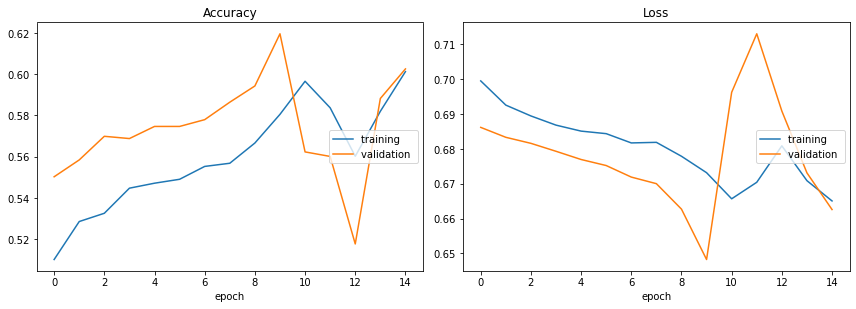

Accuracy
	training         	 (min:    0.510, max:    0.601, cur:    0.601)
	validation       	 (min:    0.518, max:    0.620, cur:    0.603)
Loss
	training         	 (min:    0.665, max:    0.699, cur:    0.665)
	validation       	 (min:    0.648, max:    0.713, cur:    0.663)
Training time: 175.879s


In [11]:
model = RNN(len(TEXT.vocab), 100, 256, 1, 0.5)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 15
path = 'imdb_rnn.pt'

train_val_model(model, criterion, optimizer, num_epochs, path)

Now let's see how the trained model performs on a test set it's never seen before.

In [12]:
model = torch.load(path)
test_loss, test_acc = evaluate(model, criterion, test_itr, device)

print(f'Test loss: {test_loss:.3f}' )
print(f'Test accuracy: {(test_acc*100):.2f}%')

Test loss: 0.648
Test accuracy: 61.69%


62% isn't a great accuracy since 50% is chance performance. We can improve the model by using pretrained word embeddings that are used to initialize the weights to the embedding layer instead of using random initialization. This change increases the model's rate of improvement and likelihood of finding a good local minimum or even global minimum for loss.

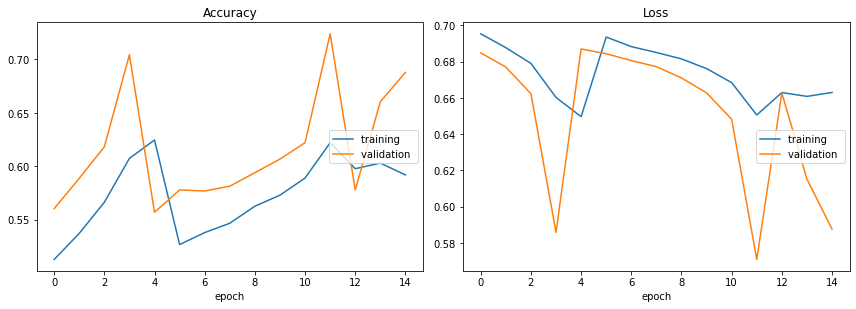

Accuracy
	training         	 (min:    0.513, max:    0.625, cur:    0.592)
	validation       	 (min:    0.557, max:    0.724, cur:    0.688)
Loss
	training         	 (min:    0.650, max:    0.695, cur:    0.663)
	validation       	 (min:    0.571, max:    0.687, cur:    0.588)
Training time: 174.030s


In [18]:
model = RNN(len(TEXT.vocab), 100, 256, 1, 0.5)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 15
path = 'imdb_rnn.pt'

model.embedding.weight.data.copy_(TEXT.vocab.vectors)
model.embedding.weight.data[TEXT.vocab.stoi[TEXT.unk_token]] = torch.zeros(model.embedding_dim)
model.embedding.weight.data[TEXT.vocab.stoi[TEXT.pad_token]] = torch.zeros(model.embedding_dim)

train_val_model(model, criterion, optimizer, num_epochs, path)

In [19]:
model = torch.load(path)
test_loss, test_acc = evaluate(model, criterion, test_itr, device)

print(f'Test loss: {test_loss:.3f}' )
print(f'Test accuracy: {(test_acc*100):.2f}%')

Test loss: 0.574
Test accuracy: 72.12%


72% accuracy is much better, but there's still room to improve. Better models such as LSTMs can be used to achieve higher accuracy, which we will explore in the next section.

## Nested Cross Validation

Using a test/val/train split is already quite effective. However, it only creates one split that can possibly create unbalanced datasets due to a random split. Consequently, a single test accuracy may not be fully representative of the model's true accuracy.

Nested cross validation is a solution to this problem. Instead of splitting the dataset once, k-fold CV splits the dataset into k equal parts known as folds. In the outer CV, one of these folds are used as a test set, while the other k-1 folds are used as a trainval set. Then in the inner CV, the trainval set is similarly split into k folds, one of which is used as a validation set while the rest are used as a training set. In the outer and inner CVs, all k folds are used as a training and validation set, respectively.

In essence, the roles of each set remain the same, but apply to multiple folds instead of one. The validation set is used for hyperparameter optimization. In this case, optimization is done using a grid search, which finds the lowest mean loss across all k inner folds. Similarly, the test set is used to find the mean test loss and accuracy across all k outer folds.

In [10]:
def grid_search(model, train_set, train_itr, val_set, val_itr, criterion, num_epochs, lr_params, device):
    val_losses = np.zeros(len(lr_params))

    for i,lr in enumerate(lr_params):
        if i==0:
            print(f'lr = {lr} ... ', end='')
        else:
            print(f'                 lr = {lr} ... ', end='')
        
        optimizer = optim.SGD(model.parameters(), lr=lr)

        for epoch in range(num_epochs):
            train(model, criterion, optimizer, train_itr, device)
        val_loss, val_acc = evaluate(model, criterion, val_itr, device)

        val_losses[i] = val_loss
        
        print('Done.')

    return val_losses

In [16]:
def cross_validate(torch_dataset, outer_kfold, num_outer_epochs, inner_kfold, num_inner_epochs, criterion, batch_size, lr_params, device, nested):
    time_start = time.clock()
    final_loss = np.zeros(outer_kfold.n_splits)
    final_acc = np.zeros(outer_kfold.n_splits)
    
    # Outer CV (trainval/test split)
    current_outer_fold = 1
    for trainval_index, test_index in outer_kfold.split(np.array(torch_dataset.examples)):

        print(f'Outer Fold {current_outer_fold}/{outer_kfold.n_splits}:')

        TEXT = data.Field(include_lengths=True)
        LABEL = data.LabelField(dtype=torch.float)
        fields = [('text',TEXT),('label',LABEL)]

        torch_dataset_arr = np.array(torch_dataset.examples)
        trainval_data = data.Dataset(torch_dataset_arr[trainval_index], fields=fields)
        test_data = data.Dataset(torch_dataset_arr[test_index], fields=fields)
        trainval_data_arr = np.array(trainval_data.examples)

        
        
        # Inner CV (train/val split)
        if (nested):
            current_inner_fold = 1
            total_val_loss = np.zeros(len(lr_params))
            
            for train_index, val_index in inner_kfold.split(trainval_data_arr):
                
                print(f'  Inner Fold {current_inner_fold}/{inner_kfold.n_splits}:')

                inner_TEXT = data.Field(include_lengths=True)
                inner_LABEL = data.LabelField(dtype=torch.float)
                fields = [('text',inner_TEXT),('label',inner_LABEL)]
                
                train_data = data.Dataset(trainval_data_arr[train_index], fields=fields)
                val_data = data.Dataset(trainval_data_arr[val_index], fields=fields)
                train_itr = data.BucketIterator(train_data, batch_size, sort_key = lambda x: len(x.text), sort_within_batch = True, device=device)
                val_itr = data.BucketIterator(val_data, batch_size, sort_key = lambda x: len(x.text), sort_within_batch = True, device=device)

                inner_TEXT.build_vocab(train_data, max_size=25000, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
                inner_LABEL.build_vocab(train_data)
                
                inner_model = RNN(len(inner_TEXT.vocab), 100, 256, 1, 0.5)
                inner_model.embedding.weight.data.copy_(inner_TEXT.vocab.vectors)
                inner_model.embedding.weight.data[inner_TEXT.vocab.stoi[inner_TEXT.unk_token]] = torch.zeros(inner_model.embedding_dim)
                inner_model.embedding.weight.data[inner_TEXT.vocab.stoi[inner_TEXT.pad_token]] = torch.zeros(inner_model.embedding_dim)

                print('    Grid Search: ',end='')
                fold_val_loss = grid_search(inner_model, train_data, train_itr, val_data, val_itr, criterion, num_inner_epochs, lr_params, device)
                total_val_loss = np.add(total_val_loss, fold_val_loss)
                
                current_inner_fold += 1

            best_lr = lr_params[np.argmin(total_val_loss)]
            print(f'  Best Learning Rate: lr = {best_lr}')

        # Non-nested CV
        else:
            criterion = optim.SGD(model.parameters(), lr=0.01)
    
    
    
        trainval_itr = data.BucketIterator(trainval_data, batch_size, sort_key = lambda x: len(x.text), sort_within_batch = True, device=device)
        test_itr = data.BucketIterator(test_data, batch_size, sort_key = lambda x: len(x.text), sort_within_batch = True, device=device)
            
        TEXT.build_vocab(trainval_data, max_size=25000, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
        LABEL.build_vocab(trainval_data)
        
        model = RNN(len(TEXT.vocab), 100, 256, 1, 0.5)
        model.embedding.weight.data.copy_(TEXT.vocab.vectors)
        model.embedding.weight.data[TEXT.vocab.stoi[TEXT.unk_token]] = torch.zeros(model.embedding_dim)
        model.embedding.weight.data[TEXT.vocab.stoi[TEXT.pad_token]] = torch.zeros(model.embedding_dim)
        optimizer = optim.SGD(model.parameters(), lr=best_lr)

        for epoch in range(num_outer_epochs):
            trainval_loss, trainval_acc = train(model, criterion, optimizer, trainval_itr, device)
            test_loss, test_acc = evaluate(model, criterion, test_itr, device)
            print(f'  Epoch {epoch+1:02} | Train Loss: {trainval_loss:.3f} | Train Acc: {trainval_acc*100:.2f}% | Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
        print('')

        final_loss[current_outer_fold-1] = test_loss
        final_acc[current_outer_fold-1] = test_acc
        current_outer_fold += 1

    print(f'Mean Test Loss: {np.mean(final_loss):.3f}')
    print(f'Mean Test Acc: {np.mean(final_acc)*100:.2f}%')
    print('Training time: %.3fs' % round(time.clock()-time_start,3))

In [17]:
cross_validate(torch_dataset=imdb,
               outer_kfold=KFold(n_splits=3, shuffle=True, random_state=0),
               num_outer_epochs=15,
               inner_kfold=KFold(n_splits=3, shuffle=True, random_state=0),
               num_inner_epochs=8,
               criterion=nn.BCEWithLogitsLoss(),
               batch_size=64,
               lr_params=[0.01,0.03,0.1],
               device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
               nested=True)

Outer Fold 1/3:
  Inner Fold 1/3:
    Grid Search: lr = 0.01 ... Done.
                 lr = 0.03 ... Done.
                 lr = 0.1 ... Done.
  Inner Fold 2/3:
    Grid Search: lr = 0.01 ... Done.
                 lr = 0.03 ... Done.
                 lr = 0.1 ... Done.
  Inner Fold 3/3:
    Grid Search: lr = 0.01 ... Done.
                 lr = 0.03 ... Done.
                 lr = 0.1 ... Done.
  Best Learning Rate: lr = 0.01
  Epoch 01 | Train Loss: 0.626 | Train Acc: 45.68% | Test Loss: 0.691 | Test Acc: 51.66%
  Epoch 02 | Train Loss: 0.623 | Train Acc: 46.80% | Test Loss: 0.690 | Test Acc: 52.88%
  Epoch 03 | Train Loss: 0.621 | Train Acc: 47.77% | Test Loss: 0.690 | Test Acc: 53.37%
  Epoch 04 | Train Loss: 0.620 | Train Acc: 47.91% | Test Loss: 0.689 | Test Acc: 53.47%
  Epoch 05 | Train Loss: 0.620 | Train Acc: 48.28% | Test Loss: 0.689 | Test Acc: 53.54%
  Epoch 06 | Train Loss: 0.618 | Train Acc: 48.72% | Test Loss: 0.689 | Test Acc: 53.84%
  Epoch 07 | Train Loss: 0.618 | T

Here we see that the mean test accuracy is much lower than without using nested CV. While the first outer fold performed fairly well, the second and third folds did not. Nested CV was able to give a better, less biased evaluation of our model than with a train/val/test split, though at the expense of a much longer computation time. 3 folds is also less than ideal, as 5 or 10 folds are generally preferred. The number of folds and epochs were only chosen to achieve a realistic computation time, as this project is primarily a proof of concept.

Now that we know the RNN model needs to be improved, we'll explore using an LSTM model in the next section.